## 1. Make basic 2d-shapes

In [88]:
import math
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageDraw
from pathlib import Path
import os
import random
from scipy.ndimage import rotate, zoom, shift, binary_erosion
from recolor_images import generate_variants
from plot_variants import show_variants_grid

In [79]:
# Set a specific seed for reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

# Base data folder
WORK = Path(os.environ.get("WORK", Path.cwd()))
SHAPES = WORK / "color-concept-entanglement" / "data" / "shapes"

SHAPE_IMGS = SHAPES / "shape_imgs"
SHAPE_MASKS = SHAPES / "shape_masks"
SHAPE_COLORED = SHAPES / "shape_colored"
SHAPES.mkdir(parents=True, exist_ok=True)
SHAPE_IMGS.mkdir(parents=True, exist_ok=True)
SHAPE_MASKS.mkdir(parents=True, exist_ok=True)
SHAPE_COLORED.mkdir(parents=True, exist_ok=True)

In [40]:
def regular_polygon(n_sides, radius, center):
    cx, cy = center
    return [
        (
            cx + radius * math.cos(2 * math.pi * i / n_sides - math.pi / 2),
            cy + radius * math.sin(2 * math.pi * i / n_sides - math.pi / 2),
        )
        for i in range(n_sides)
    ]


def make_shape(
    shape: str,
    size: int = 512,
    line_width: int = 12,
    fg="black",
    bg="white",
):
    """
    Outline via fill–subtract.
    Triangle is slightly thickened for visual consistency.
    """
    img = Image.new("RGB", (size, size), bg)
    draw = ImageDraw.Draw(img)

    center = (size // 2, size // 2)
    outer_r = int(size * 0.35)

    # 🔧 triangle compensation factor
    if shape == "triangle":
        inner_r = outer_r - int(line_width * 1.6)
    else:
        inner_r = outer_r - line_width

    if inner_r <= 0:
        raise ValueError("line_width too large for image size")

    if shape == "circle":
        draw.ellipse(
            [
                center[0] - outer_r,
                center[1] - outer_r,
                center[0] + outer_r,
                center[1] + outer_r,
            ],
            fill=fg,
        )
        draw.ellipse(
            [
                center[0] - inner_r,
                center[1] - inner_r,
                center[0] + inner_r,
                center[1] + inner_r,
            ],
            fill=bg,
        )
    else:
        sides = {
            "triangle": 3,
            "square": 4,
            "pentagon": 5,
            "hexagon": 6,
        }[shape]

        outer = regular_polygon(sides, outer_r, center)
        inner = regular_polygon(sides, inner_r, center)

        draw.polygon(outer, fill=fg)
        draw.polygon(inner, fill=bg)

    return img

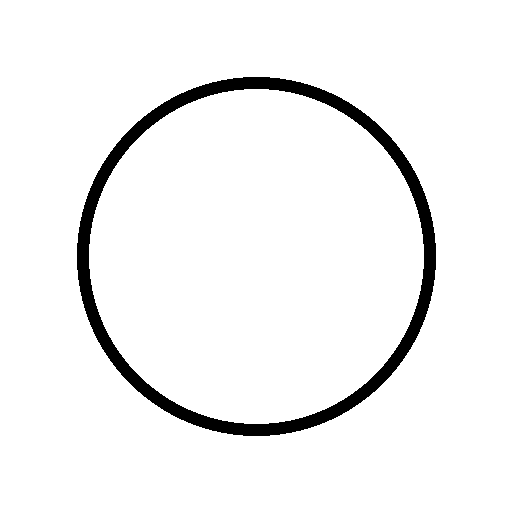

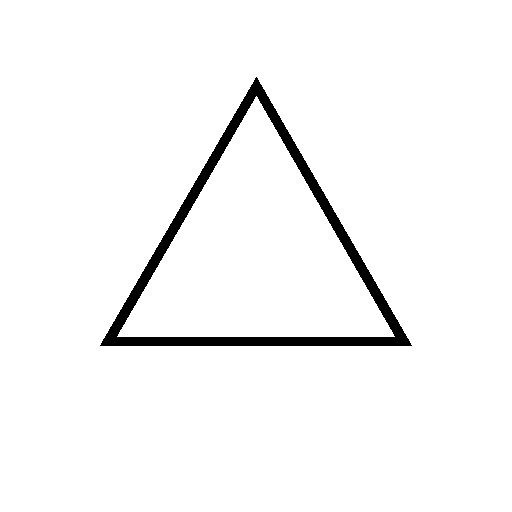

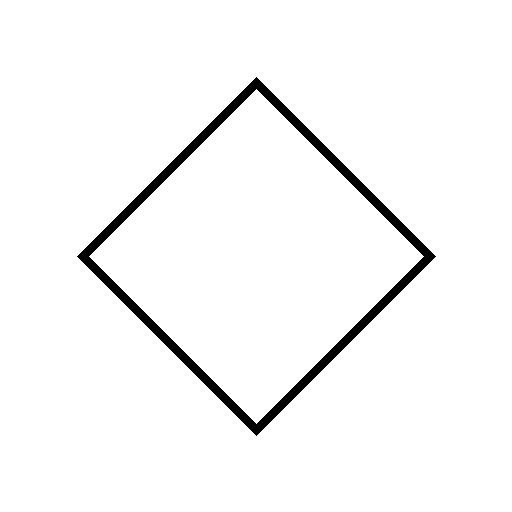

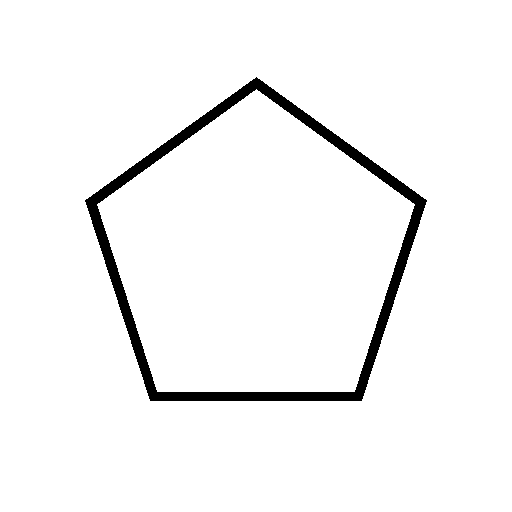

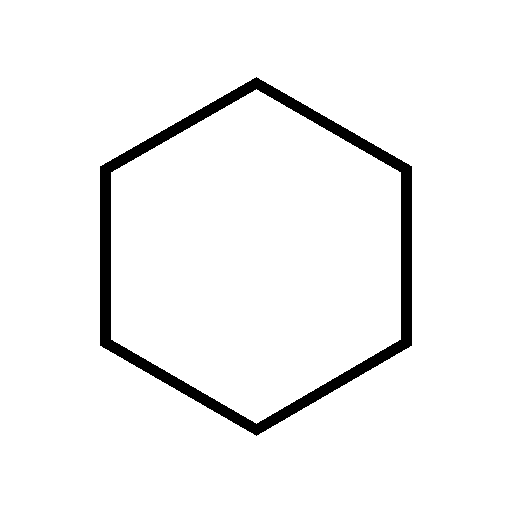

In [41]:
make_shape("circle").show()
make_shape("triangle").show()
make_shape("square").show()
make_shape("pentagon").show()
make_shape("hexagon").show()

## 2. Create mask for each shape 

In [42]:
def make_mask(
    shape: str,
    size: int = 512,
    radius_frac: float = 0.35,
):
    """
    Binary FG mask of the shape (filled).
    """
    img = Image.new("L", (size, size), 0)
    draw = ImageDraw.Draw(img)

    c = size // 2
    r = int(size * radius_frac)

    if shape == "circle":
        draw.ellipse(
            [c - r, c - r, c + r, c + r],
            fill=1,
        )
    else:
        sides = {
            "triangle": 3,
            "square": 4,
            "pentagon": 5,
            "hexagon": 6,
        }[shape]

        points = [
            (
                c + r * math.cos(2 * math.pi * i / sides - math.pi / 2),
                c + r * math.sin(2 * math.pi * i / sides - math.pi / 2),
            )
            for i in range(sides)
        ]
        draw.polygon(points, fill=1)

    return np.array(img, dtype=np.uint8)

In [ ]:
def center_crop_or_pad(src, target_shape):
    out = np.zeros(target_shape, dtype=src.dtype)

    sh, sw = src.shape
    th, tw = target_shape

    h = min(sh, th)
    w = min(sw, tw)

    sy = (sh - h) // 2
    sx = (sw - w) // 2
    ty = (th - h) // 2
    tx = (tw - w) // 2

    out[ty:ty+h, tx:tx+w] = src[sy:sy+h, sx:sx+w]
    return out

def sample_transform():
    return dict(
        rotation_deg=random.uniform(0, 360),
        scale=random.uniform(0.7, 1.2),
        translate_xy=(
            random.randint(-50, 50),
            random.randint(-50, 50),
        ),
    )

## 3. Augment shape dataset by simple transformations

In [ ]:
def transform_mask(mask, rotation_deg=0.0, scale=1.0, translate_xy=(0, 0)):
    m = mask.astype(float)

    if rotation_deg != 0:
        m = rotate(m, rotation_deg, reshape=False, order=0)

    if scale != 1.0:
        z = zoom(m, scale, order=0)
        m = center_crop_or_pad(z, mask.shape)

    if translate_xy != (0, 0):
        m = shift(
            m,
            shift=(translate_xy[1], translate_xy[0]),
            order=0,hape_
            mode="constant",
            cval=0,
        )

    return m > 0.5

def mask_to_outline(mask, thickness_px):
    eroded = binary_erosion(mask, iterations=thickness_px)
    return mask ^ eroded


def render_outline(mask, outline_thickness=12):
    outline = mask_to_outline(mask, outline_thickness)
    img = np.ones(mask.shape, dtype=np.uint8) * 255
    img[outline] = 0
    return Image.fromarray(img)

In [ ]:
def shape_augmentation(
    shapes,
    size=512,
    n_variants=5,
    outline_thickness=12,
    show=False,
):  
    rows = []

    for shape in shapes:
        print(f"\n=== {shape.upper()} ===")

        base_mask = make_mask(shape, size=size)
        base_fg = base_mask.sum()
        print(f"Base FG pixels: {base_fg}")

        for v in range(n_variants):
            params = sample_transform()
            mask = transform_mask(base_mask, **params)
            img = render_outline(mask, outline_thickness)

            name = f"{shape}_v{v:01d}.png"
            mask_name = f"{shape}_v{v:01d}_mask.png"

            img_path = SHAPE_IMGS / name
            mask_path = SHAPE_MASKS / mask_name

            img.save(img_path)
            Image.fromarray(mask.astype("uint8") * 255).save(mask_path)

            fg = mask.sum()
            print(
                f"  variant {v:01d} | "
                f"rot={params['rotation_deg']:.1f}° "
                f"scale={params['scale']:.3f} "
                f"shift={params['translate_xy']} "
                f"FG={fg}"
            )

            rows.append(
                {
                    "object": f"{shape}_v{v:01d}",
                    "shape": shape,
                    "image_path": str(img_path),
                    "cv_mask_path": str(mask_path),
                }
            )

            if show:
                img.show()
    shape_df = pd.DataFrame(rows)
    shape_df.to_csv(SHAPES / "shape_dataset.csv", index=False)

    return shape_df

In [ ]:
shapes = ["circle", "triangle", "square", "pentagon", "hexagon"]

df = shape_augmentation(
    shapes,
    size=512,
    n_variants=5,
    outline_thickness=10,
    show=True,  # set True to visually inspect
)

## 4. Color shapes and background

In [81]:
# Define custom grid for coloring
pct_schedule = list(range(0, 11, 1)) + list(range(20, 110, 10))
print(pct_schedule)

colors = ["red", "brown", "pink", "green", "blue", "yellow", "purple", "orange", "grey", "black"]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [83]:
# Generate variants for all images in df
for _, row in tqdm(df.iterrows(), total=len(df), desc="Generating color variants"):
    for color in colors:
        paths = generate_variants(
            row=row,
            target_color=color,
            out_dir=SHAPE_COLORED,
            rng=rng,
            use_patches=True,
            patch_size=16,
            step_size=10,
            mode="sequential",
            pct_schedule=pct_schedule
        )

Generating color variants: 100%|██████████| 25/25 [27:32<00:00, 66.12s/it]


In [85]:
# Define which range of image variants to plot
tail_range = list(range(0, 6)) + list(range(95, 101))
ten_increase = list(range(0, 110, 10))
compact = [0, 10, 50, 90, 100]

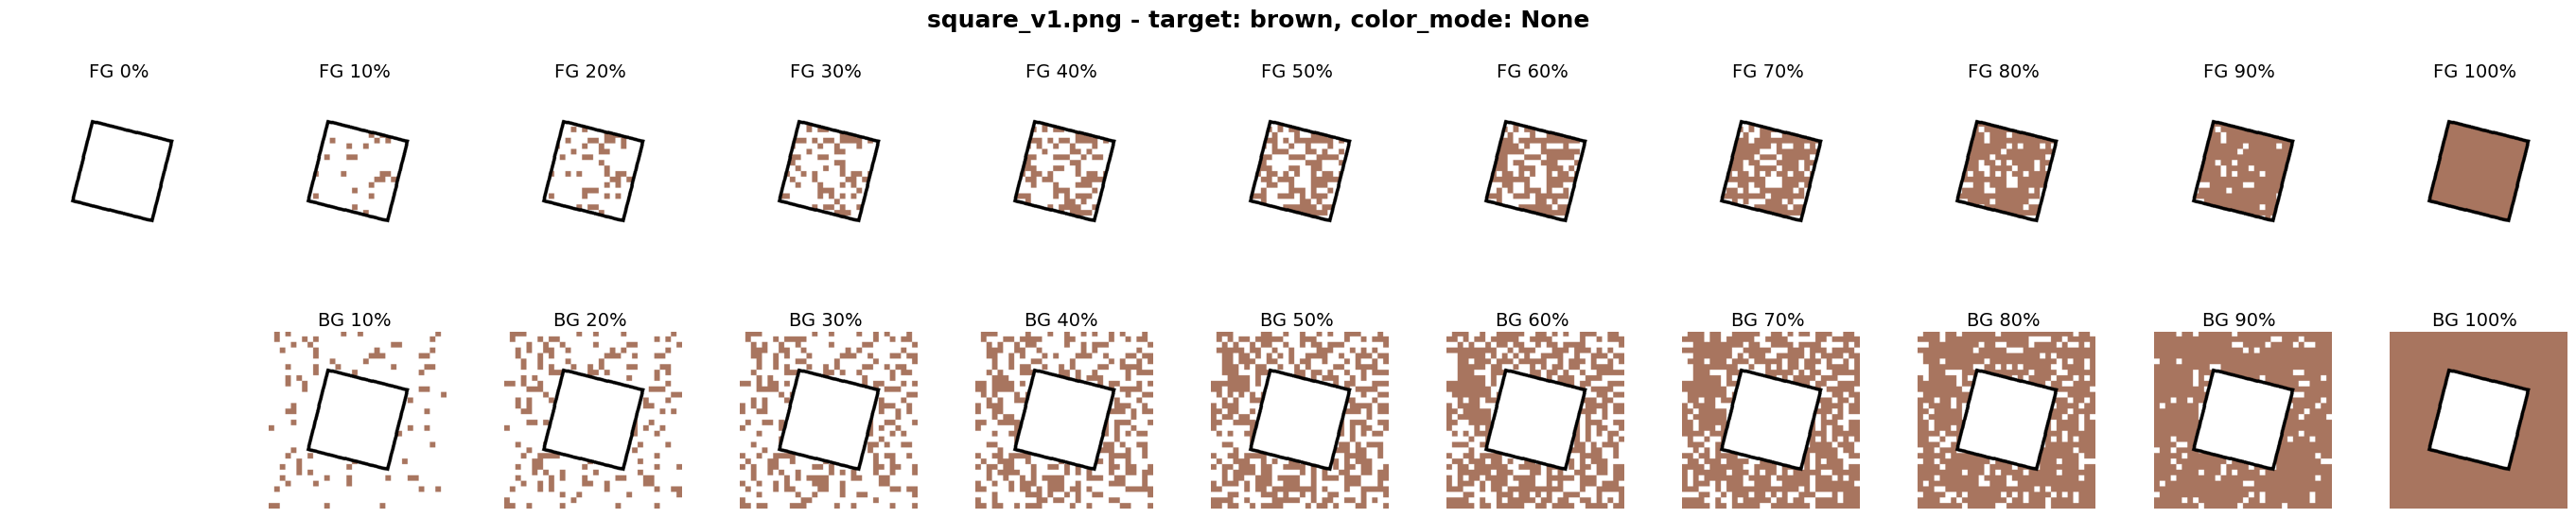

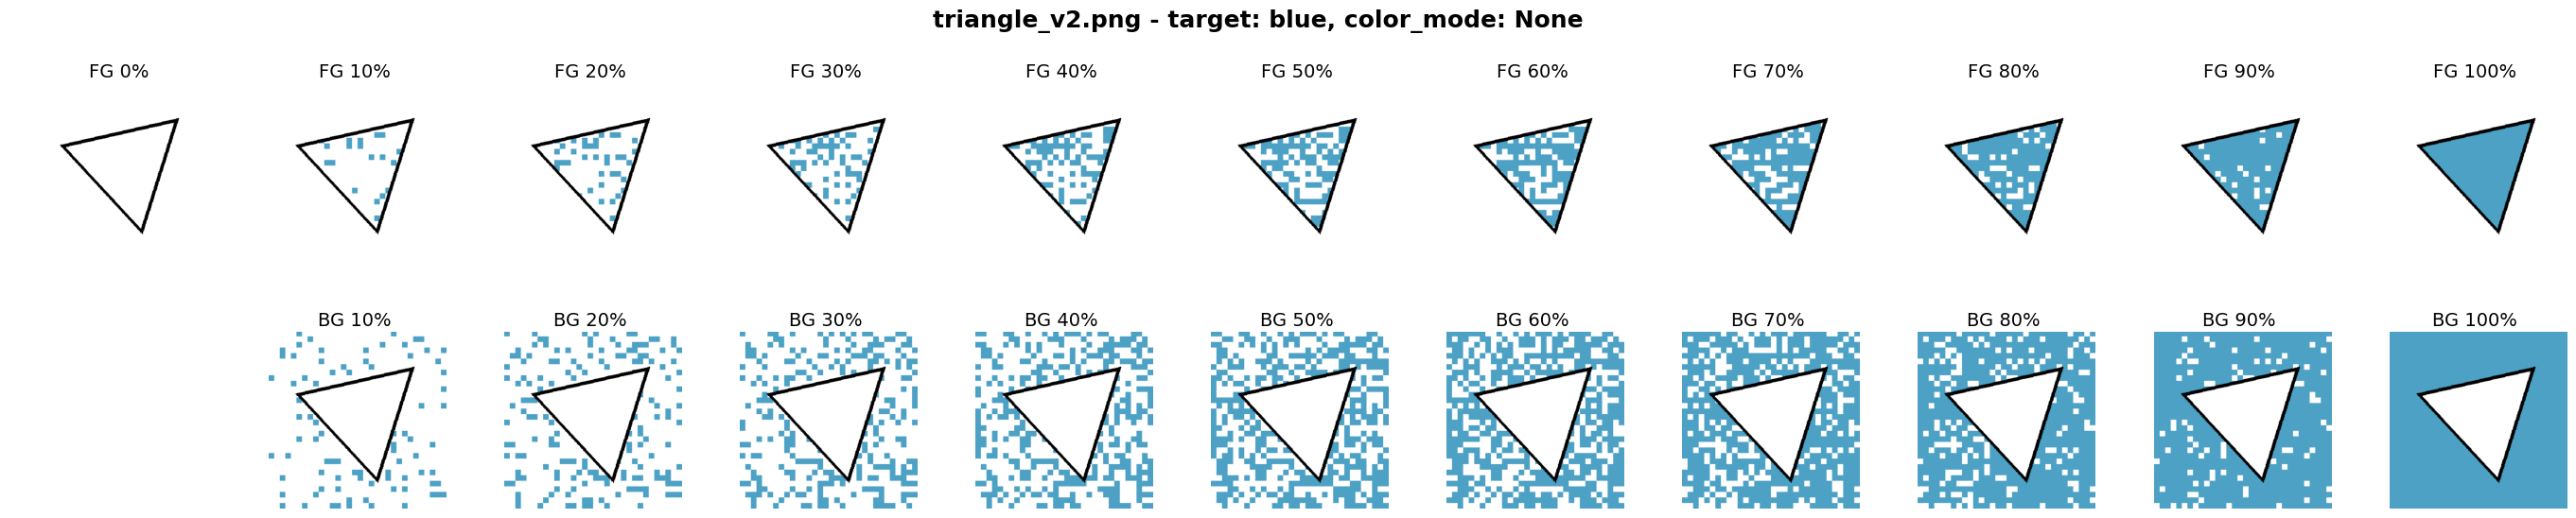

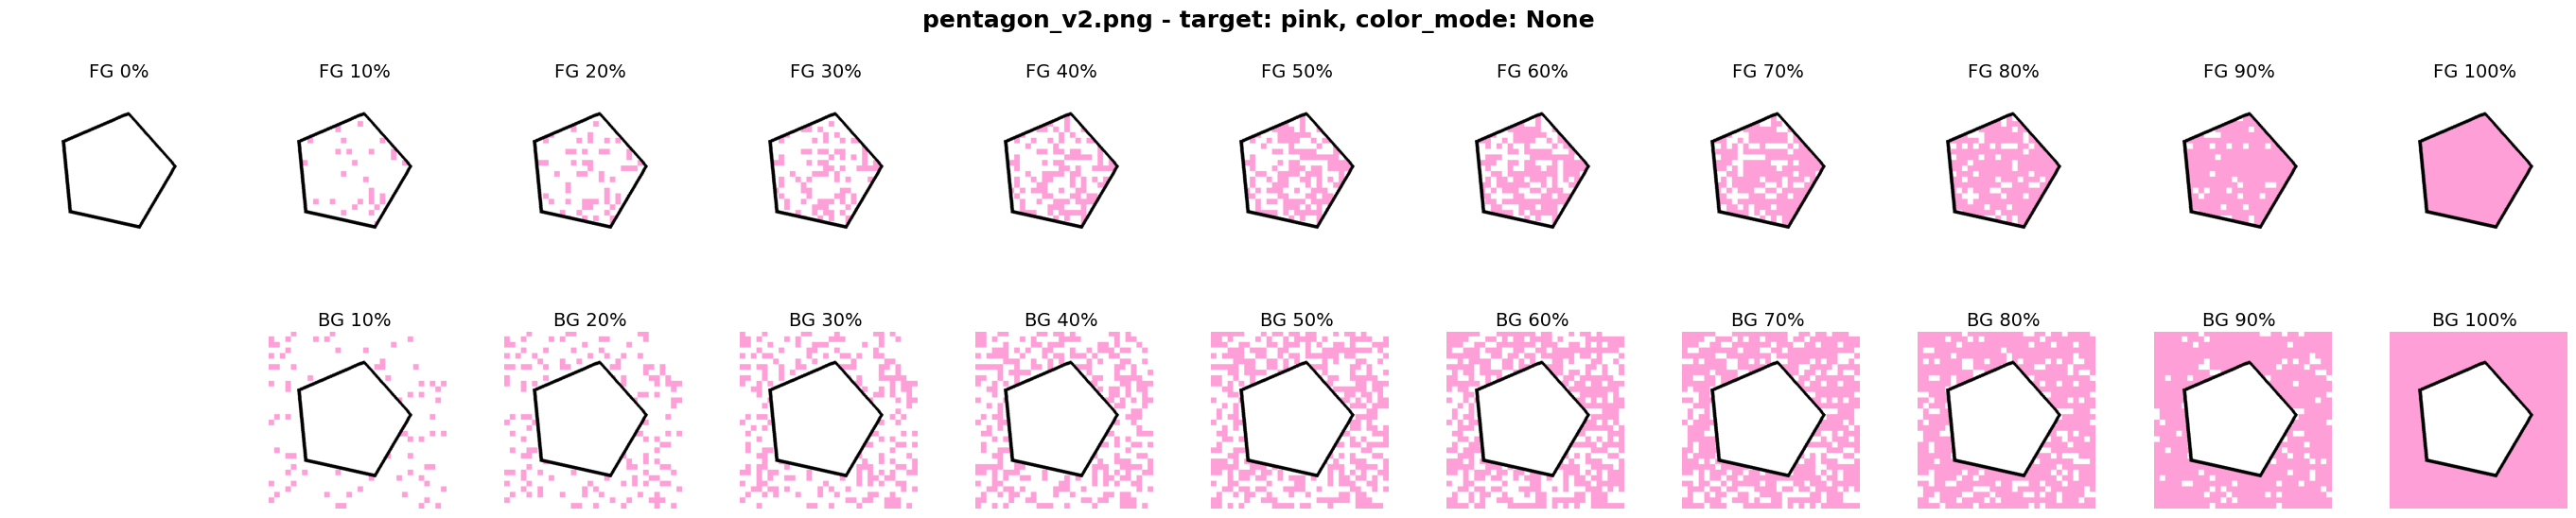

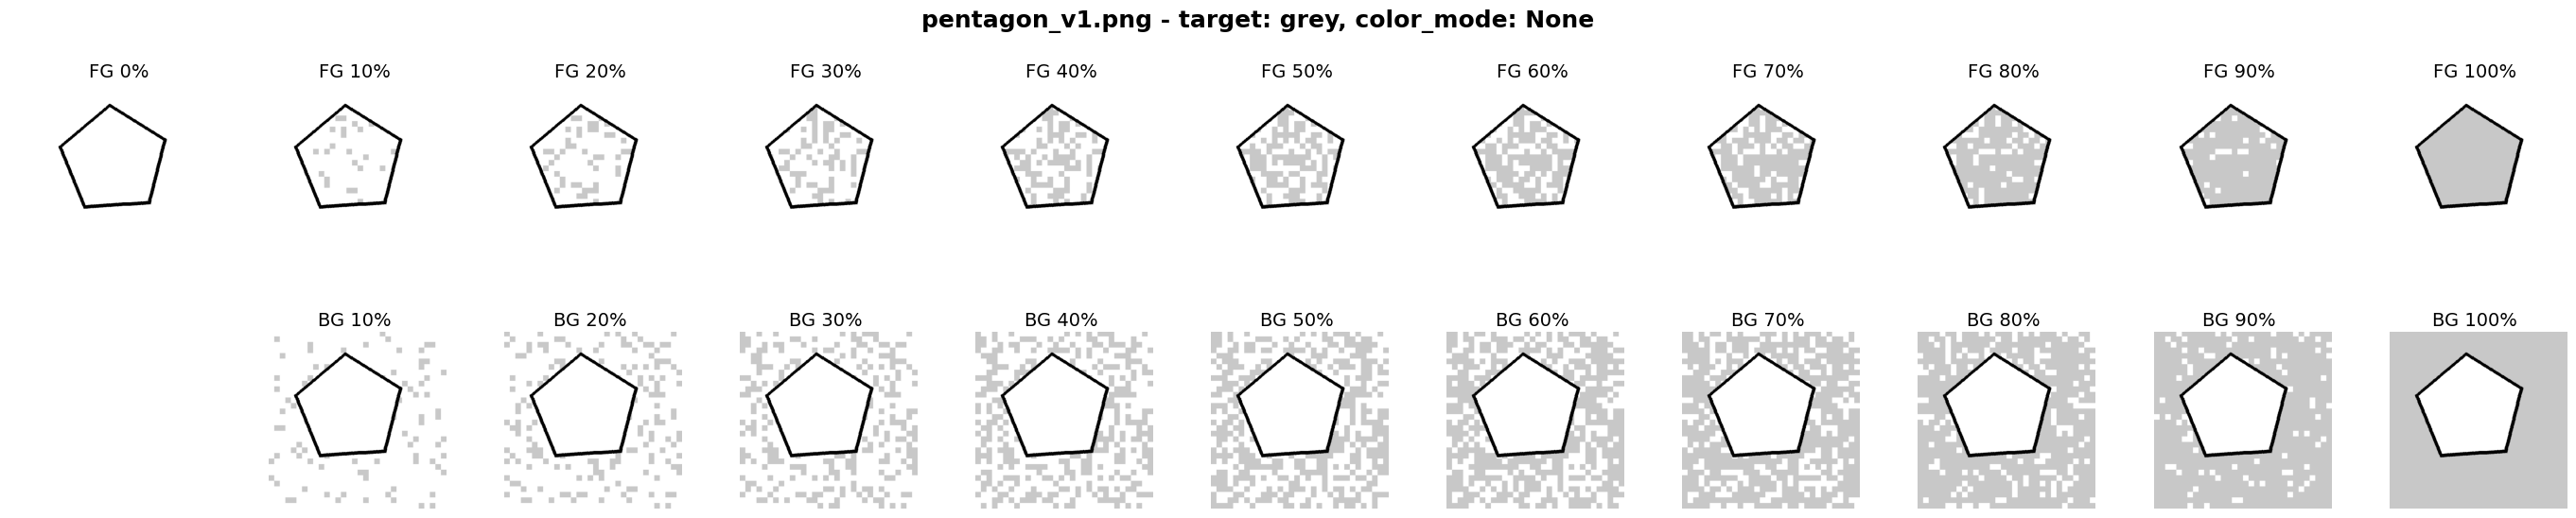

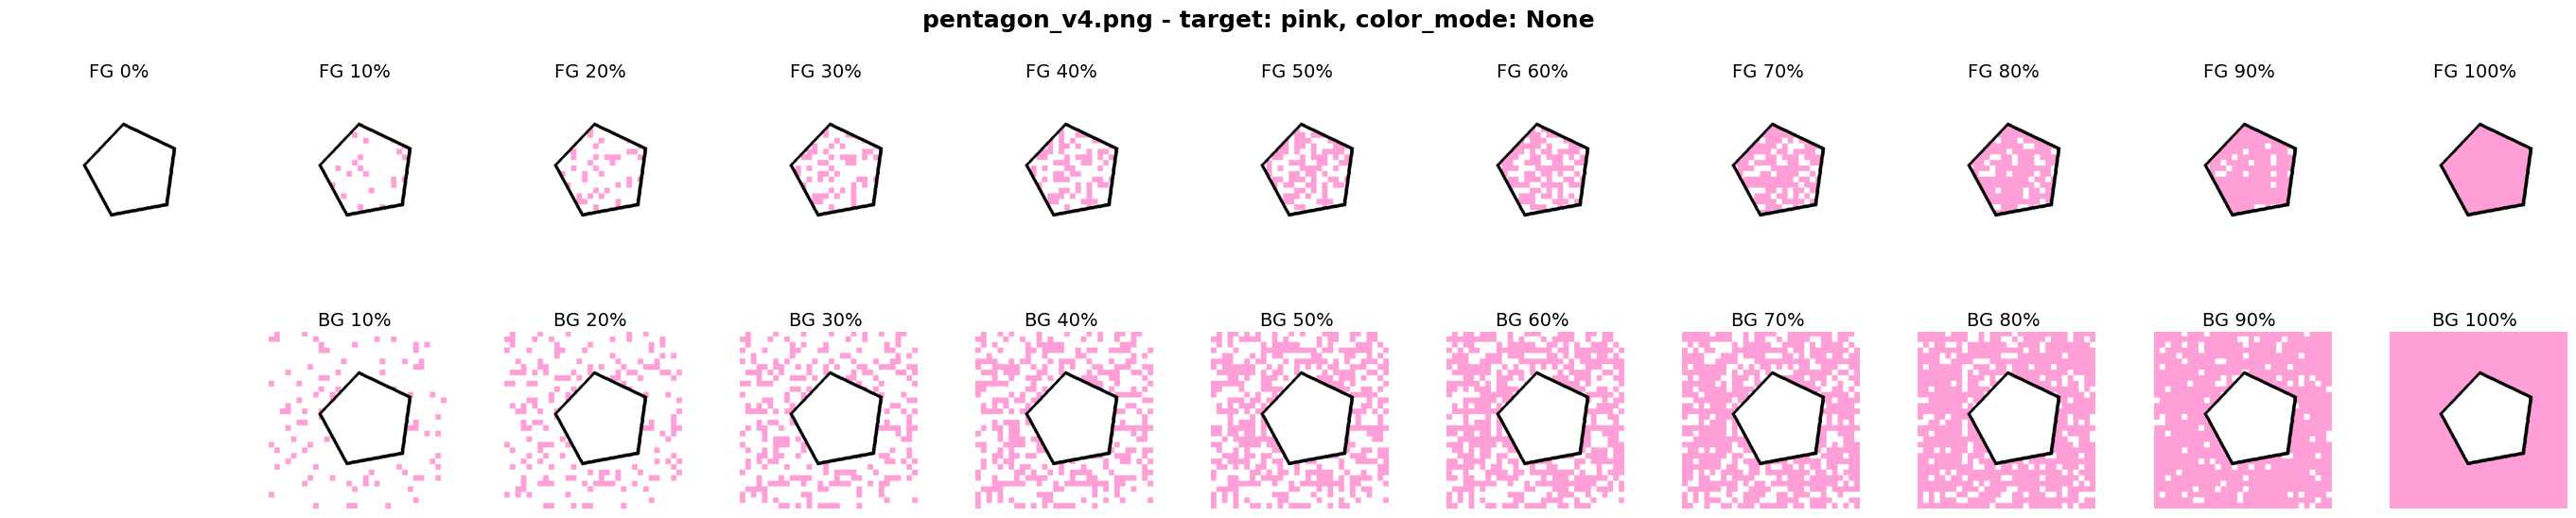

In [90]:
for idx, row in df.sample(5).iterrows():
    c = random.choice(colors)
    show_variants_grid(row['image_path'], c, SHAPE_COLORED, pct_range=ten_increase)